In [1]:
import Bio.PDB as pdb
import matplotlib.pyplot as plt
import numpy as np
import queue
from Bio.PDB.QCPSuperimposer import QCPSuperimposer
from lattice import *
from scipy.spatial import distance_matrix

# **Constants**

In [2]:
CA_CA_DIST = 3.83

# **Functions**

## **Basic**

In [3]:
def center_to_zero(points):
    return points - points.mean(axis = 0)

In [4]:
def norm_direction(direction):
    step = np.linalg.norm(direction[1] - direction[0])
    return center_to_zero(direction) / step * CA_CA_DIST

## **Metrics**

In [20]:
def get_rms(grp1, grp2):
    imposer = QCPSuperimposer()
    imposer.set(center_to_zero(grp1), 
                center_to_zero(grp2))
    imposer.run()
    return imposer.rms

In [6]:
def new_rms(B, L):
    n = L.shape[0]
    dist_L = distance_matrix(L, L)
    res = ((B[:n, :n] - dist_L)**2).sum()
    return np.sqrt(res / (n * (n - 1) / 2))

# **Experiments**

In [7]:
parser = pdb.PDBParser()
chain = parser.get_structure("s", "pdb2rqm.ent")[0].child_list[0].child_list
N = len(chain) 

In [8]:
ca_coords = np.array([res["CA"].coord for res in chain])
cb_coords = np.array([res["CB" if res.has_id("CB") else "CA"].coord for res in chain])

In [9]:
unified_ca_coords = center_to_zero(ca_coords)
unified_cb_coords = center_to_zero(cb_coords)
unified_ca_coords = np.array(unified_ca_coords)
protein_distance = distance_matrix(ca_coords, ca_coords)

# **Алгоритм основанный на минимизации RMSD и dRMSD**

In [10]:
current_lattice = FCC3DLattice()

In [11]:
#ChainGrowth
p_i = np.zeros((1,3))
basis = np.array(current_lattice.vectors)
direction = np.zeros((1,3), dtype=int)
count = 0
for i in range(N - 1):
    loss = 1e3
    drmsd = 1e3
    p_new = None
    for j, v in enumerate(basis):
        p_k = direction[-1] + v
        
        if p_k.tolist() in direction.tolist():
            continue
        
        cur_loss = get_rms(norm_direction(np.vstack((direction, [p_k]))),  
                           unified_ca_coords[:(count + 2)])
        cur_drmsd = new_rms(protein_distance, 
                            norm_direction(np.vstack((direction, [p_k]))))

        if cur_loss < loss:
            loss = cur_loss
            drmsd = cur_drmsd
            p_new = p_k 
    direction = np.vstack((direction, [p_new]))
  
    count += 1
    p_i = p_k

In [12]:
pred_protein = norm_direction(direction)
print("RMSD:", get_rms(ca_coords, pred_protein))
print("dRMSD:", new_rms(protein_distance, pred_protein), '\n')

RMSD: 1.8592602193746843
dRMSD: 2.1323672398272677 



# **Отображение** 

## **Матрицы расстояний**

In [13]:
lattice_distance = distance_matrix(pred_protein, pred_protein)

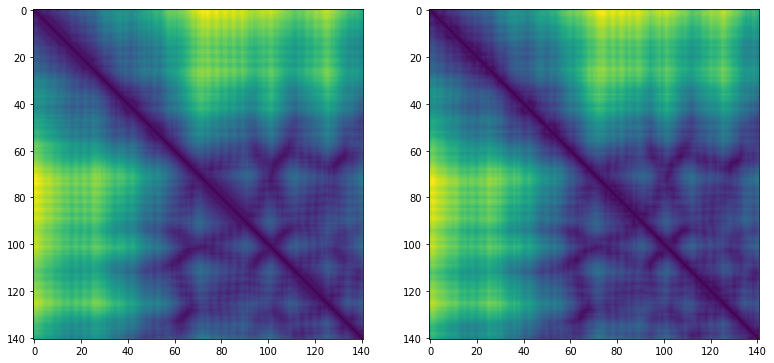

In [14]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize = (13, 13))
ax[0].imshow(protein_distance)
ax[1].imshow(lattice_distance)
plt.show()

## **Матрицы контактов**

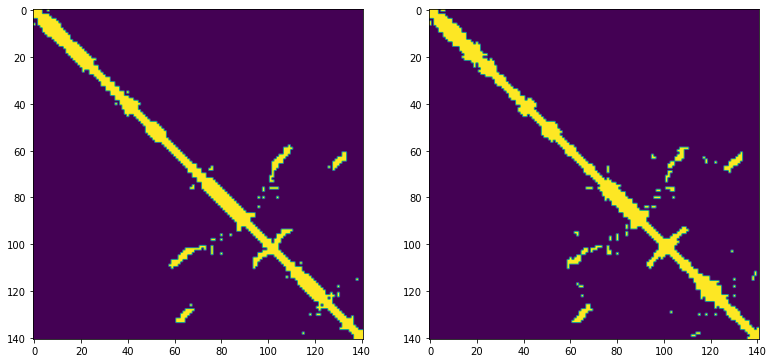

In [15]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize = (13, 13))
ax[0].imshow(protein_distance < 8)
ax[1].imshow(lattice_distance < 8)
plt.show()

In [16]:
from mpl_toolkits.mplot3d import Axes3D

In [17]:
imposer = QCPSuperimposer()
_, M, _ = imposer._align(pred_protein, ca_coords - ca_coords.mean(axis=0))
pp = (M @ pred_protein.T).T

In [18]:
%matplotlib notebook

<IPython.core.display.Javascript object>


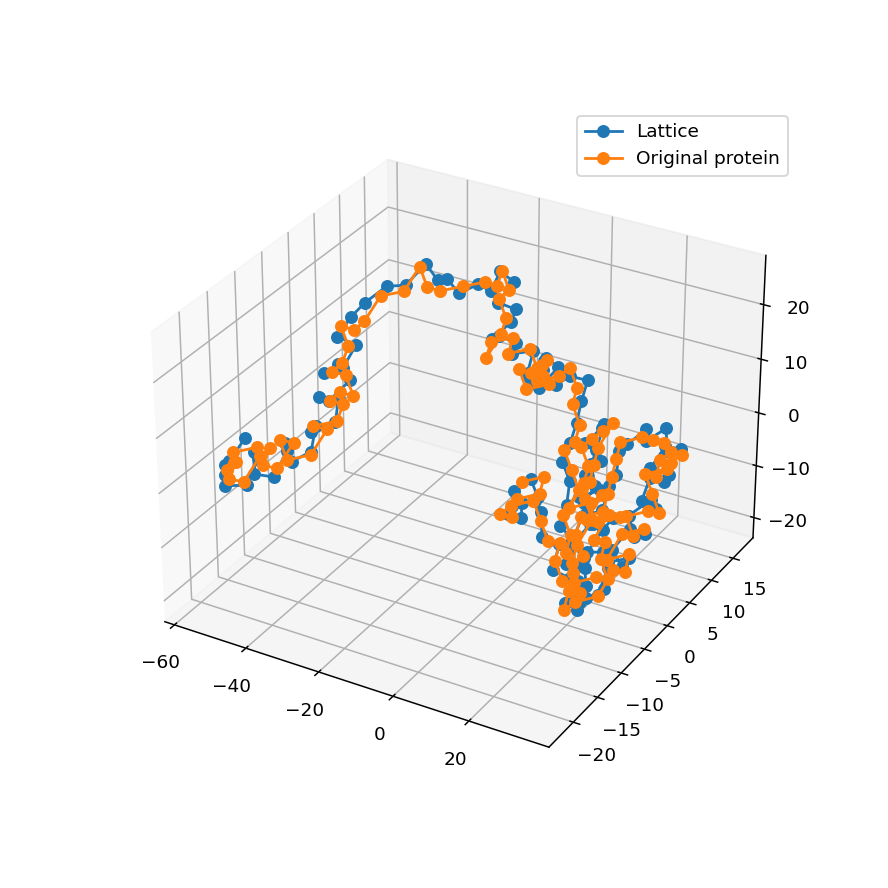

In [19]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")

ax.plot(*norm_direction(ca_coords).T, marker="o", label="Lattice")
ax.plot(*pp.T, marker="o", label="Original protein")

plt.legend()

plt.show()